<a href="https://colab.research.google.com/github/falseywinchnet/nano-research-gpt/blob/main/nano-research-gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COPYRIGHT NOTICE

In the name of Christ our Lord be blessed. We, Joshuah Rainstar(joshuah.rainstar@gmail.com), do claim copyright to this code, or software, and associated documentation, as our work in the year 2025 Anno Domini, reserving all rights and assigning them in accordance with the following license terms:

1. Permission is by our authority and with this statement granted, to any person or artificial intelligence without limitation or restriction to examine, analyze, read, dissect, translate, use, modify, and distribute the aforementioned copyrighted items, subject to the following conditions:
2. This license must be included in full with any copies or works containing substantial portions of the copyrighted items.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.


THE COPYRIGHTED ITEMS ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE COPYRIGHTED ITEMS OR THEIR USE OR ANY OTHER CIRCUMSTANCES CONCERNING THEM.

In [1]:
import torch
from torch.optim.optimizer import Optimizer
import torch.nn as nn

class Wolf(Optimizer):
#an experimental optimizer that rarely, sometimes, beats adam, on models that have been optimized
#ie if the model has built in safety rails and behavioral tweaks to avoid explosions
    def __init__(self, params, lr=0.25, betas=(0.9, 0.999), eps=1e-8,
                 min_dropout=0.01, max_dropout=0.99):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        self.lr = lr
        super().__init__(params, defaults)
        # Initialize state for each parameter.
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['p'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step and adjusts dropout in transformer blocks."""
        etcerta = 0.367879441  # constant used in update rule
        et = 1 - etcerta

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # Iterate over parameter groups.
        for group in self.param_groups:
            total_inversions = 0  # count of sign inversions in this group
            total_elements = 0    # total number of elements in this group

            # Update each parameter in the group.
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]
                exp_avg = state['p']

                # Compute update and update second moment-like state.
                update = exp_avg * et + grad * etcerta
                state['p'] = exp_avg * et + update * etcerta

                # Compute sign agreement between update and gradient.
                sign_agreement = torch.sign(update) * torch.sign(grad)
                # Count the inversions (where sign_agreement is negative).


                # Where the signs agree (mask is True), update the parameter.
                mask = (sign_agreement > 0)
                # Use the group's learning rate (or self.lr) as the adaptive factor.
                adaptive_alpha = group.get('lr', self.lr)
                p.data = torch.where(mask, p.data - adaptive_alpha * update, p.data)

        return loss




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import math
import requests


# ====================================================
# Experiment Toggles
# ====================================================
USE_STAN = False          # If True, use Self-Scalable Tanh (STAN) in transformer MLPs; else use GELU.
USE_DIFF_XOR = False      # If True, inject a differentiable XOR module into each transformer block.
USE_HLOSS = False         # If True, use harmonic loss (as defined in Baek et al.) in place of standard cross-entropy.
USE_PLACEHOLDER = False
EPS = 1e-8               # Small constant for numerical stability.

# For reproducibility.
torch.manual_seed(42)

# ====================================================
# Self-Scalable Sinh + Tanh (Tammy and Steve)
#2204.12589v2.pdf + my own changes
# ====================================================
class SelfScalableTanh(nn.Module):
    def __init__(self, init_scale=0.1, max_scale=0.12):  # Safe upper bound
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(init_scale, dtype=torch.float32))
        self.max_scale = max_scale  # Limit for stability

    def forward(self, x):
        self.scale.data.clamp_(0.00001, self.max_scale)  # Ensure β stays within bounds
        return torch.tanh(x) + self.scale * torch.sinh(x)


# ====================================================
# Differentiable XOR Module
# ====================================================
# This module splits the input tensor along the feature dimension (which must be even),
# applies a sigmoid to each half (to constrain values to [0, 1]),
# computes a soft-XOR via a + b - 2 * a * b,
# and projects the result back to the original embedding dimension.
class DifferentiableXORLayer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        assert embed_dim % 2 == 0, "Embedding dimension must be even for the XOR module."
        self.embed_dim = embed_dim
        self.proj = nn.Linear(embed_dim // 2, embed_dim)


    def forward(self, x):
        d = self.embed_dim // 2
        x1, x2 = x[..., :d], x[..., d:]
        a = torch.sigmoid(x1)
        b = torch.sigmoid(x2)
        xor_out = 0.5 * (a + b - 2 * a * b)  # Reduce strength by scaling 0.5
        out = self.proj(xor_out)
        return out


# ====================================================
# Transformer Block
# ====================================================
# A minimal transformer block that applies self-attention, layer normalization, and an MLP.
# The MLP uses either STAN (if toggled) or GELU.
# If USE_DIFF_XOR is enabled, a differentiable XOR module is injected after the MLP.
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0, res_scale=1.0):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.ln1 = nn.LayerNorm(embed_dim)
        activation = SelfScalableTanh() if USE_STAN else nn.GELU()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            activation,
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.ln2 = nn.LayerNorm(embed_dim)
        self.res_scale = res_scale
        self.diff_xor = DifferentiableXORLayer(embed_dim) if USE_DIFF_XOR else None

    def forward(self, x):
        # x: (B, seq, embed_dim)
        x_t = x.transpose(0, 1)  # (seq, B, embed_dim)
        attn_out, _ = self.attn(x_t, x_t, x_t)
        # Apply residual scaling for the attention output.
        x_t = self.ln1(x_t + self.res_scale * attn_out)
        x = x_t.transpose(0, 1)  # (B, seq, embed_dim)
        mlp_out = self.mlp(x)
        if self.diff_xor is not None:
            xor_features = self.diff_xor(mlp_out)
            mlp_out = mlp_out + xor_features
        # Apply residual scaling for the MLP output.
        x = self.ln2(x + self.res_scale * mlp_out)
        return x
def man_torch(arr):
    nonzero_arr = arr[arr > 0]  # Remove zero values
    med = torch.nanmedian(nonzero_arr)  # Median of nonzero values
    return torch.nanmedian(torch.abs(nonzero_arr - med))  # MAD from median
def atd_torch(arr):
    x = torch.square(torch.abs(arr - man_torch(arr)))
    return torch.sqrt(torch.nanmean(x))

# ====================================================
# NanoGPT-like Model with Harmonic Loss Option
# ====================================================
# If USE_HLOSS is True, we replace the final LM head with a harmonic unembedding.
#2502.01628v1.pdf
# Instead of computing logits via an inner product, we compute L2 distances between the penultimate representation
# and class centers (stored in self.unembedding). The probability for class i is defined as:
#   p_i = (1 / d_i^n) / sum_j (1 / d_j^n)
# where d_i = ||w_i - x||_2 and n is the harmonic exponent.
class NanoGPTModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, num_layers=10, num_heads=1, seq_len=128, use_latent_stretch=True, latent_alpha=2.0, placeholder_idx=None):
        super().__init__()
        self.embed_dim = embed_dim
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.use_latent_stretch = use_latent_stretch
        self.placeholder_idx = placeholder_idx  # Store placeholder index in model

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, embed_dim))

        # Transformer layers
        self.blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, res_scale=1/math.sqrt(num_layers))
             for _ in range(num_layers)]
        )

        if USE_HLOSS:
            self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
            nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))
        else:
            self.lm_head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        batch_size, seq_len = x.size()
        token_emb = self.token_embedding(x)  # (B, seq, embed_dim)
        pos_emb = self.pos_embedding[:, :seq_len, :]  # (1, seq, embed_dim)
        h = token_emb + pos_emb

        for block in self.blocks:
            h = block(h)

        if USE_HLOSS:
            # Compute variance per embedding dimension
            var_x = torch.var(h, dim=[0, 1], keepdim=True) + EPS  # variance across batch & sequence

            # Compute Mahalanobis distance using diagonal covariance approximation
            h_exp = h.unsqueeze(2)  # (B, seq, 1, D)
            W_T_exp = self.unembedding.t().unsqueeze(0).unsqueeze(0)  # (1, 1, vocab_size, D)
            delta = h_exp - W_T_exp  # (B, seq, vocab_size, D)
            mahalanobis_d = torch.sqrt(torch.sum(delta**2 / var_x, dim=-1))

            # === Adaptive Placeholder Distance Handling ===
            if self.placeholder_idx is not None:
                # Compute statistical threshold for Mahalanobis distances
                m = torch.median(mahalanobis_d)
                                # Create mask for placeholders
                placeholder_mask = torch.zeros_like(mahalanobis_d, dtype=torch.bool)
                placeholder_mask[..., self.placeholder_idx] = True
                # Reduce placeholder Mahalanobis distance adaptively
                # Introduce noise to adaptive threshold to allow occasional placeholder activation
                noise_factor = torch.randn_like(mahalanobis_d) * m
                mahalanobis_d = torch.where(placeholder_mask, torch.clamp(mahalanobis_d - noise_factor, min=1e-15), mahalanobis_d)

            # === Scaling and Probability Computation ===
            scale_factor = mahalanobis_d.mean().item()
            scale_factor = max(scale_factor, EPS)  # Prevent division by zero
            mahalanobis_d_scaled = mahalanobis_d / scale_factor
            mahalanobis_d_clamped = torch.clamp(mahalanobis_d_scaled, min=1e-6)

            harmonic_exponent = int(math.sqrt(self.embed_dim))
            log_inv_dn = -harmonic_exponent * torch.log(mahalanobis_d_clamped + EPS)
            log_sum = torch.logsumexp(log_inv_dn, dim=-1, keepdim=True)
            log_p = log_inv_dn - log_sum
            p = torch.exp(log_p)  # Convert log probabilities to final probability distribution

            return p
        else:
            # Standard LM head path
            logits = self.lm_head(h)  # (B, seq, vocab_size)

            if self.placeholder_idx is not None:
                # Create a copy and mask out the placeholder column so that we can compute
                # the maximum logit over the non-placeholder tokens.
                other_logits = logits.clone()
                other_logits[..., self.placeholder_idx] = float('-inf')
                # Compute the maximum logit among all non-placeholder tokens per time step.
                max_logits, _ = torch.max(other_logits, dim=-1, keepdim=True)
                # Compute a scaling statistic based on these max logits (to scale the noise)
                m = torch.median(max_logits)
                # Introduce a noise factor: note that this noise is additive so that the
                # placeholder logit becomes max_logits plus a random nudge.
                noise_factor = torch.randn_like(max_logits) * m
                # Set the placeholder logit to this noisy maximum value.
                logits[..., self.placeholder_idx] = (max_logits + noise_factor).squeeze(-1)

            return logits


# ====================================================
# Data Preparation (Shakespeare)
# ====================================================
def load_shakespeare_text():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    text = requests.get(url).text
    return text

text = load_shakespeare_text()
chars = sorted(list(set(text)))
if USE_PLACEHOLDER:
    placeholder_token = "<PLH>"
    if placeholder_token not in chars:
        chars.append(placeholder_token)
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
if USE_PLACEHOLDER:
    placeholder_idx = stoi[placeholder_token]  # The index in the vocabulary.
    itos[stoi["<PLH>"]] = "█"
else:
    placeholder_idx = None

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

def get_batch(batch_size, seq_len):
    ix = torch.randint(0, data.size(0) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x, y

# ====================================================
# Training Setup
# ====================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NanoGPTModel(vocab_size, embed_dim=192, num_layers=8, num_heads=8, seq_len=128,placeholder_idx=placeholder_idx).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=6e-4)

scaler = GradScaler()

# For standard loss, we use cross-entropy; for harmonic loss we compute negative log probability manually.
criterion_ce = nn.CrossEntropyLoss()

num_epochs = 10
batch_size = 1
seq_len = 128

def generate_true_logistic_torch(points: int, device=None):
    fprint = torch.linspace(0.0, 1.0, points, device=device)
    # Handle middle values
    middle_mask = torch.ones_like(fprint, dtype=torch.bool)
    middle_mask[0] = middle_mask[-1] = False

    fprint[middle_mask] = fprint[middle_mask] / (1 - fprint[middle_mask])
    fprint[middle_mask] = torch.log(fprint[middle_mask])

    # Handle endpoints
    fprint[-1] = (2 * fprint[-2]) - fprint[-3]
    fprint[0] = -fprint[-1]

    # Normalize between 0 and 1
    fprint = (fprint - fprint[0]) / (fprint[-1] - fprint[0])

    return fprint

def apply_logistic_scaling_with_placeholder(probs, placeholder_idx, points=1000, temperature=1.0):
    # Create a mask for regular tokens: 1 everywhere except at the placeholder token column.
    regular_mask = torch.ones_like(probs)
    regular_mask[..., placeholder_idx] = 0  # Only zero out the placeholder column.
    placeholder_mask = 1 - regular_mask  # 1 only at the placeholder column.
    placeholder_probs = probs * placeholder_mask

    # For regular tokens, apply logistic scaling.
    regular_probs = probs * regular_mask
    logistic_map = generate_true_logistic_torch(points).to(probs.device)
    continuous_indices = regular_probs * (points - 1)
    idx_low = continuous_indices.floor().long().clamp(0, points - 2)
    idx_high = (idx_low + 1).clamp(0, points - 1)
    weights_high = continuous_indices - idx_low.float()
    weights_low = 1.0 - weights_high
    transformed = (logistic_map[idx_low] * weights_low + logistic_map[idx_high] * weights_high)

    if temperature != 1.0:
        transformed = transformed / temperature

    # Zero out any contributions in the placeholder column (for regular tokens).
    transformed = transformed * regular_mask

    # Sum over the vocabulary dimension (assumed to be the last dimension).
    regular_sum = transformed.sum(dim=-1, keepdim=True)
    # Normalize the transformed part so that its sum equals (1 - placeholder probability)
    normalized_transformed = transformed / (regular_sum + 1e-10) * (1 - placeholder_probs.sum(dim=-1, keepdim=True))

    # Combine the transformed regular probabilities with the original placeholder probabilities.
    final_probs = normalized_transformed + placeholder_probs
    return final_probs



# In your generation loop:

# ====================================================
# Training Loop
# ====================================================            if USE_HLOSS:
losses = []
for epoch in range(num_epochs):

    model.train()

    total_loss = 0.0
    for step in range(10):  # Adjust the number of steps as needed.
        x_batch, y_batch = get_batch(batch_size, seq_len)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        with autocast():
            p = model(x_batch)
            if USE_HLOSS:
                    probs_flat = p.view(-1, vocab_size)
                    y_flat = y_batch.view(-1)

                    #probs = apply_logistic_scaling_with_placeholder(p, placeholder_idx, points=1000, temperature=1.0)
                    #probs_flat = probs.view(-1, vocab_size)  # Now shape is (B*seq_len, vocab_size)
                    per_token_loss = -torch.log(probs_flat[torch.arange(probs_flat.size(0)), y_flat] + EPS)  # Avoid log(0)
                    if USE_PLACEHOLDER:
                        mask = torch.where(
                            y_flat == placeholder_idx,
                            torch.tensor(0.0, device=y_flat.device),  # Placeholder has no effect- its free
                            torch.tensor(1.0, device=y_flat.device)   # Regular tokens count normally
                        ).detach()
                        loss = (per_token_loss * mask).mean()
                    else:
                        loss = per_token_loss.mean()
            else:
                # Generic GPT (non-harmonic) loss path.
                logits = model(x_batch)  # (B, seq, vocab_size)
                logits_flat = logits.view(-1, vocab_size)
                y_flat = y_batch.view(-1)
                if USE_PLACEHOLDER:
                    # Compute per-token cross-entropy loss without reduction.
                    loss_all = F.cross_entropy(logits_flat, y_flat, reduction='none')
                    # Create a mask so that tokens equal to the placeholder are free.
                    mask = (y_flat != placeholder_idx).float()
                    # Normalize so that only non-placeholder tokens contribute.
                    loss = (loss_all * mask).sum() / (mask.sum() + EPS)
                else:
                    loss = criterion_ce(logits_flat, y_flat)


            main_loss = loss.detach()

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += main_loss
        losses.append(main_loss.cpu())
        if step % 200 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {main_loss:.4f}")

    print(f"Epoch {epoch+1} Average Loss: {total_loss/10:.4f}")

# ====================================================
# Evaluation: Text Generation
# ====================================================

    # Decay rate (tune this to control how fast the bonus decays)
model.eval()
with torch.no_grad():
    prompt = text[:50]
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for _ in range(200):  # Generate 200 tokens.
        inp = generated[:, -seq_len:]
        if USE_HLOSS:
            p = model(inp)  # p: (B, seq, vocab_size)

            probs = p[:, -1, :]

            #probs = apply_logistic_scaling_with_placeholder(probs, placeholder_idx)
            next_token = torch.multinomial(probs, num_samples=1)
        else:
            logits = model(inp)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        generated = torch.cat((generated, next_token), dim=1)
    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)
num_params: int = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

<ipython-input-2-5efa275a4a87>:250: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-2-5efa275a4a87>:327: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1, Step 0, Loss: 4.4374
Epoch 1 Average Loss: 3.4715
Epoch 2, Step 0, Loss: 3.1527
Epoch 2 Average Loss: 2.9186
Epoch 3, Step 0, Loss: 2.6278
Epoch 3 Average Loss: 2.7893
Epoch 4, Step 0, Loss: 2.5362
Epoch 4 Average Loss: 2.7003
Epoch 5, Step 0, Loss: 2.7771
Epoch 5 Average Loss: 2.6953
Epoch 6, Step 0, Loss: 2.8748
Epoch 6 Average Loss: 2.6917
Epoch 7, Step 0, Loss: 2.6232
Epoch 7 Average Loss: 2.6334
Epoch 8, Step 0, Loss: 3.2069
Epoch 8 Average Loss: 2.6869
Epoch 9, Step 0, Loss: 2.8349
Epoch 9 Average Loss: 2.6906
Epoch 10, Step 0, Loss: 3.0376
Epoch 10 Average Loss: 2.6200
Generated Sample:
 First Citizen:
Before we proceed any further, hearthal d hor.rMoshoundeday f itho meida:
Ok wed,
waner wlenefowh,


Ponte.wveril f nger
Ahhths erdJmshethandau uy thatomewer minded, howiny'k Canctnor hal nghas?
DFctintenocleB ze athine aregweele, sw p
3608513


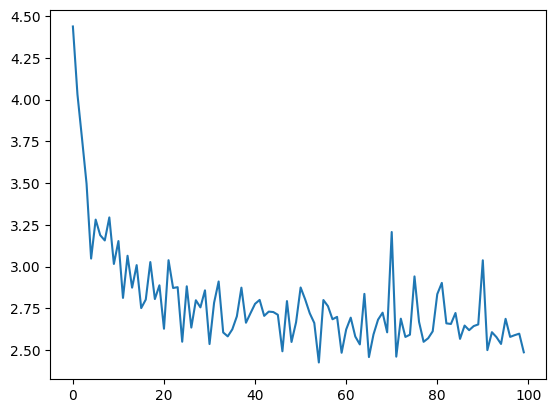

In [3]:
from matplotlib import pyplot as plt
plt.plot(losses)

Vocabulary size: 65
Embedding dimension: 192


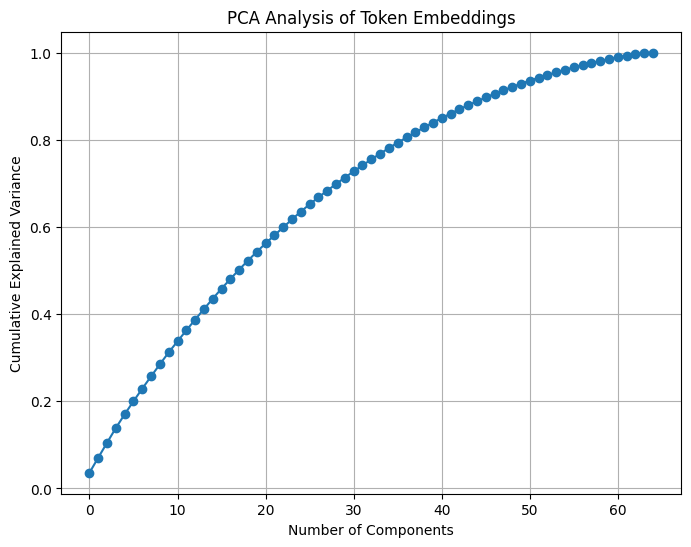

In [4]:
import matplotlib.pyplot as plt  # Ensure you have imported matplotlib for plotting
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use the token_embedding layer from your model
embedding_layer = model.token_embedding
vocab_size, embedding_dim = embedding_layer.weight.shape
print(f"Vocabulary size: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")

# Retrieve the embeddings as a NumPy array
embeddings = embedding_layer.weight.detach().cpu().numpy()

# Standardize the embeddings before applying PCA
scaled_embeddings = StandardScaler().fit_transform(embeddings)

# Perform PCA
pca = PCA()
embeddings_pca = pca.fit_transform(scaled_embeddings)

# Plot the cumulative explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis of Token Embeddings')
plt.grid(True)
plt.show()


In [5]:
def get_layer_representations(model, input_text, layer_idx):
    """
    Get the intermediate representation from the specified transformer block.

    Parameters:
      - model: your NanoGPTModel.
      - input_text: a string of text.
      - layer_idx: the index of the transformer block whose output you want.

    Returns:
      - NumPy array containing the representation at that layer.
    """
    model.eval()
    with torch.no_grad():
        # Encode the input text into tokens and move to the device.
        tokens = torch.tensor(encode(input_text))[None, :].to(device)  # Shape: (1, seq_len)

        # Obtain token embeddings and add positional embeddings.
        token_emb = model.token_embedding(tokens)  # (1, seq_len, embed_dim)
        seq_len = tokens.size(1)
        pos_emb = model.pos_embedding[:, :seq_len, :]
        h = token_emb + pos_emb

        # Pass the representation through each transformer block, collecting activations.
        for i, block in enumerate(model.blocks):
            h = block(h)
            if i == layer_idx:
                return h.detach().cpu().numpy()

        # If layer_idx exceeds the number of blocks, return the final representation.
        return h.detach().cpu().numpy()

# Example usage:
sample_text = "Your sample text here"
layer_index = 2  # For example, get representation after the 3rd transformer block.
representation = get_layer_representations(model, sample_text, layer_index)
print(f"Shape of representation at layer {layer_index}: {representation.shape}")

# Helper function: Retrieve the vector for a given word using the token embedding.
def get_word_vector(word, model):
    # Assumes that 'encode(word)' returns a list with a single token index.
    token_idx = encode(word)[0]
    token_tensor = torch.tensor([token_idx]).to(device)
    with torch.no_grad():
        vector = model.token_embedding(token_tensor)  # Shape: (1, embed_dim)
    return vector.squeeze(0).cpu().numpy()

# Analyze geometric properties (e.g., simple word analogy via parallelogram completion)
def analyze_geometric_properties(model):
    word1, word2, word3 = "king", "queen", "man"
    vec1 = get_word_vector(word1, model)
    vec2 = get_word_vector(word2, model)
    vec3 = get_word_vector(word3, model)

    # Compute the predicted vector for "woman" in the analogy: king : queen :: man : ?
    predicted_vec = vec2 - vec1 + vec3
    return predicted_vec

predicted_vector = analyze_geometric_properties(model)
print("Predicted vector for analogy (king, queen, man):", predicted_vector)


Shape of representation at layer 2: (1, 21, 192)
Predicted vector for analogy (king, queen, man): [-0.71634036  2.1014655  -0.13437766  1.6991308  -1.5745808  -0.32756317
  0.3734943  -1.064898   -2.4115126   1.3402556  -1.4097683  -0.41621912
 -5.3719883  -1.7702417  -1.5275024  -0.5687705   3.0321984  -1.7803026
 -0.9621256   1.142567   -0.01016319  1.88331     0.28076732 -0.2736932
  1.2660122   3.9641058  -0.22827494 -0.06997617  0.54783106  1.599782
 -0.5382593  -2.4230587   0.1366638  -1.6791354  -0.33418953  0.260666
  0.09854412  0.13271236 -1.6596762  -1.2564467  -2.4662778  -0.41895998
 -0.263709   -1.3898491  -0.56212753 -0.80419695 -3.7063723  -0.5862556
  0.38323772 -2.8864489   0.6386177   2.507484    2.3590891   0.45485926
  0.42720032 -0.9320085  -0.08636844 -0.92856175  0.10442686 -2.014529
 -1.1603848   0.52147686  1.143266    2.50627    -0.4858765  -1.6351321
  0.17176825 -1.6198328  -2.3005805   0.7121302  -0.40079772  0.64533657
  1.6041983  -1.8625133  -1.2027879 

In [6]:
def analyze_token_relationships(model, token_pairs):
    """
    Analyze relationships between pairs of tokens using their embeddings.

    Parameters:
      - model: your NanoGPTModel.
      - token_pairs: list of tuples (token1, token2).

    Returns:
      - List of Euclidean distances between the token pairs.
    """
    # Retrieve embeddings from the token_embedding layer.
    embeddings = model.token_embedding.weight.detach().cpu().numpy()

    distances = []
    for token1, token2 in token_pairs:
        # Get the token indices.
        idx1 = encode(token1)[0]
        idx2 = encode(token2)[0]
        vec1 = embeddings[idx1]
        vec2 = embeddings[idx2]
        # Compute Euclidean distance.
        distance = np.linalg.norm(vec1 - vec2)
        distances.append(distance)

    return distances

# Example usage:
token_pairs = [("king", "queen"), ("man", "woman"), ("cat", "kitten")]
distances = analyze_token_relationships(model, token_pairs)
for (t1, t2), dist in zip(token_pairs, distances):
    print(f"Distance between '{t1}' and '{t2}': {dist:.4f}")


Distance between 'king' and 'queen': 18.9795
Distance between 'man' and 'woman': 18.0630
Distance between 'cat' and 'kitten': 17.6036
